# Week report  28 May

Current focus:
 - O1: Explore if lower temperatures yields different information decay curves for psycho graph
     - Specifically we expect the most important node to not be depression but a node with lower degree
 - O2: Attempt results on bigger graph
     - I took a dataset rom the cat cortex (65 Nodes). A bigger dataset will have larger degree variety and thus will be more in line with previously obtained results.
 - O3: Cythonize code
     - Through small testing I noticed a massive performance increase. Hence I decided to statically type parts of the code

Focus for next week:
 1. Sadly, write up the results for psychonetwork; for small graphs the assumption does not hold that higher degree has diminished impact than lower degree nodes. 
 2. Either figure out the memory issues, or drastically undersample the state space for larger graph (cat cortex, or c. elegans).
 3. Relate most impactful node to increase in node probability, i.e. does the slowest decay relate to the largest delta in hellinger distance as a function of time.
 

# O1
We hypothesize that the current problem is that we are sampling in the 'linear part' of the impact curve. As I reminder a schematic representation of the curve below. For moderate temperatures there is linear part wherer as the degree increases, so does the impact for that node. The idea is that as we lower the temperature. The updateTypeof the curve will move towards the left. 

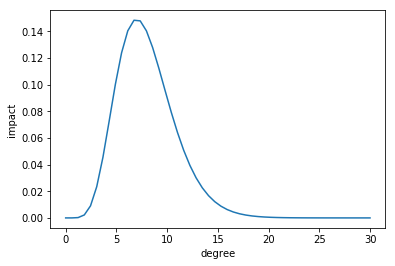

In [37]:
import matplotlib.pyplot as plt, numpy as np
from scipy.stats import gamma # look sorta like gamma
fig, ax = plt.subplots()
x = np.linspace(0, 30)
y = gamma.pdf(x, 8)
ax.plot(x, y)
plt.setp(ax, **dict(xlabel = 'degree', ylabel = 'impact'));

We believed that if the temperature is lowered, the updateTypeof the curve will shift towards the left, and collapses to be a exponential decay. 

So I re-ran t he simulations with a varying degree lower than the midpoint of the graph we had prior. 

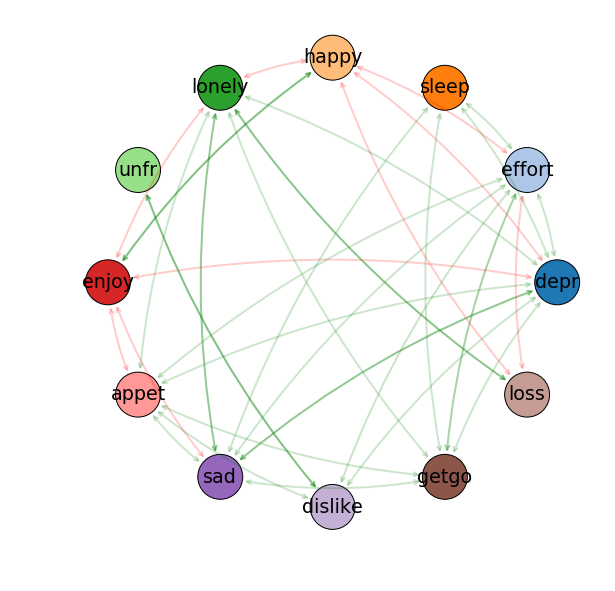

In [80]:
import plotting as plotz, networkx as nx, fastIsing
dataDir = 'Psycho' # relative path careful
df    = IO.readCSV('{}/Graph_min1_1.csv'.format(dataDir), header = 0, index_col = 0)
h     = IO.readCSV('{}/External_min1_1.csv'.format(dataDir), header = 0, index_col = 0)

graph   = nx.from_pandas_adjacency(df) 
fig, ax = plt.subplots()
model = fastIsing.Ising(graph, 1)
plotz.addGraphPretty(model, ax)
ax.axis('off');
# plt.rcParams['figure.figsize'] = (40, 40)

I will now plot the MI decay curves (source style) for differrent temperatures. The colors of the nodes match the one in the graph above.

# Source MI decay curve per temperature

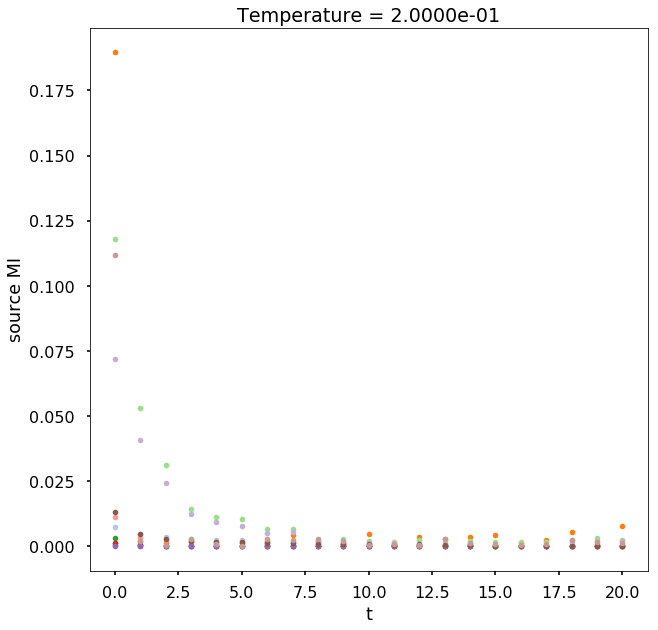

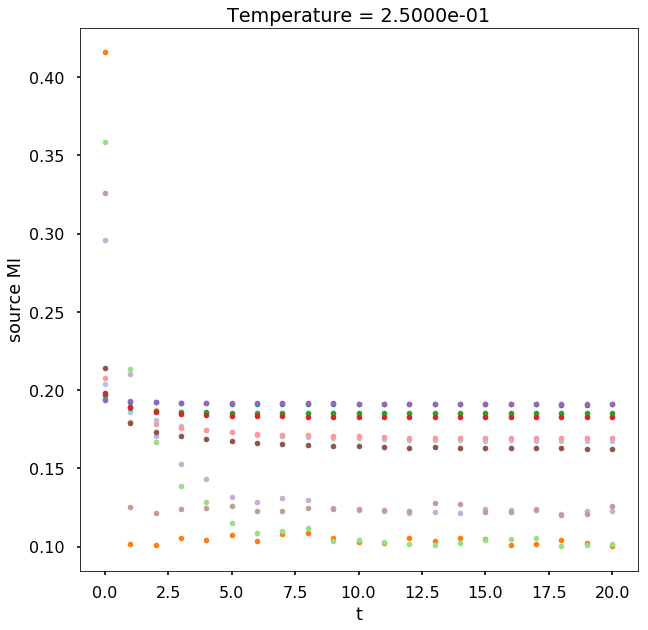

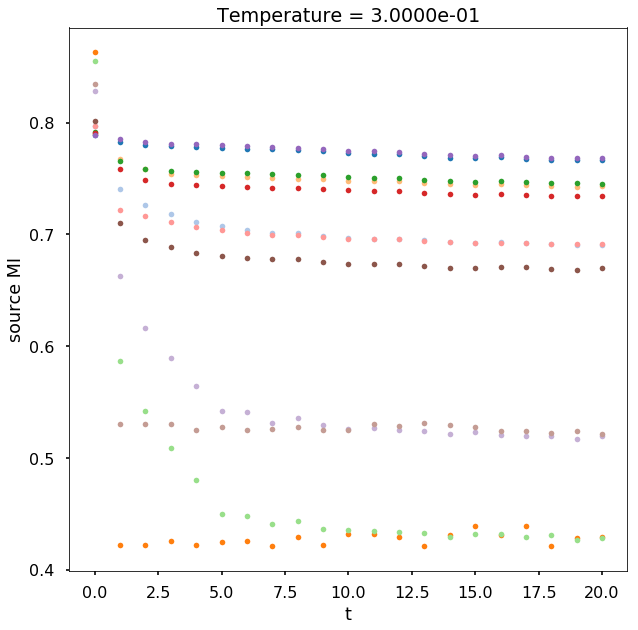

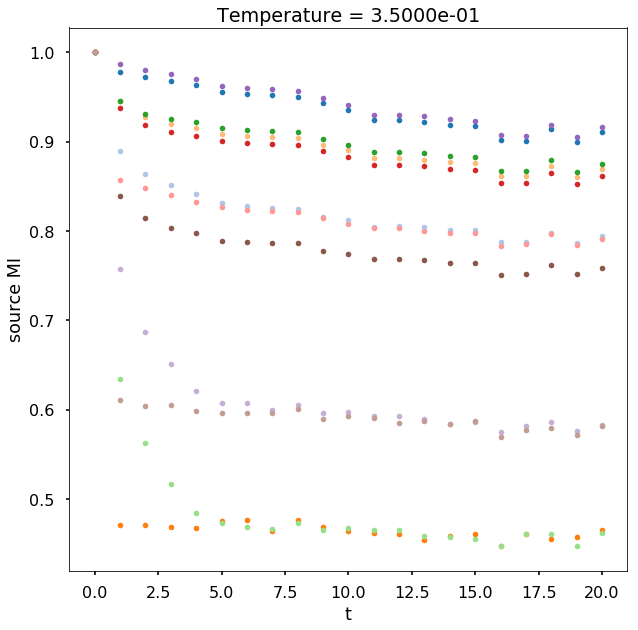

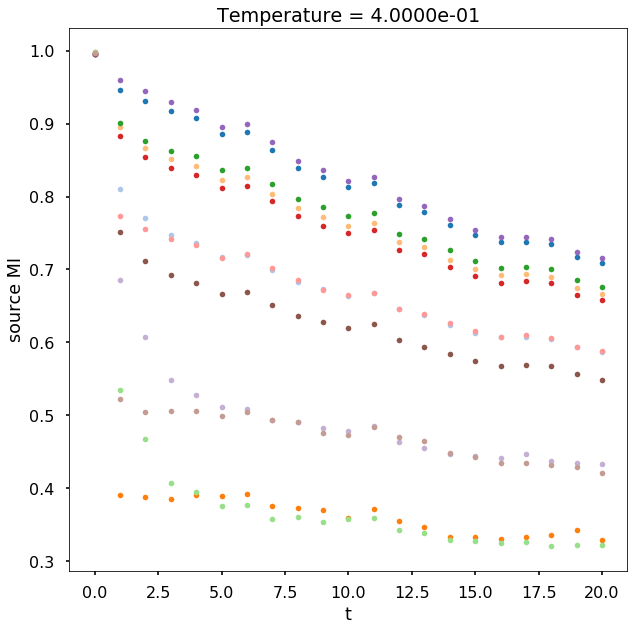

In [77]:
import os, IO, seaborn as sb
data = '/media/casper/518B815F43D50878/'
colors = plt.cm.tab20(np.arange(12))
for file in os.listdir(data):
    if file.endswith('12.pickle'):
        I = IO.loadPickle(f'{data}{file}')['I']
        fig, ax = plt.subplots()
        [ax.plot(i, '.', color = c) for i, c in zip(I.T, colors)]
        t = file.split('T=')[1].split('_')[0]
        plt.setp(ax, **dict(xlabel = 't', ylabel = 'source MI', title = f'Temperature = {t}'))
# plt.rcParams['figure.figsize'] = (10,10)
sb.set_context('poster')

## Observations

It does seem to be the case that for lower temperatures, the smaller degree nodes tend to flip more. Specifically, we seethat *unfr* and *dislike* share the most information with the system state. However, generally speaking the entropy has decreased to low levels in general. The degree distribution per node is given below; *unfr* has degree 1 and *dislike* has degree 4. 

The pattern for higher temperatures seems relatively consistent, i.e. the same ordering of decay for higher temperatures.

The network seems to be frozen for these lower temperatures,  and given the low variety of degrees I think it will be hard for the hypothesis to be true. Hence, I decided to look at slightly larger systems.

In [64]:
nx.degree(graph)

DegreeView({'depr': 9, 'effort': 8, 'sleep': 4, 'happy': 5, 'lonely': 7, 'unfr': 1, 'enjoy': 5, 'appet': 7, 'sad': 7, 'dislike': 4, 'getgo': 6, 'loss': 3})

# O2

I believe that the size of the graph for the psychonetwork doesnt have the variety in the degree distribution to get the shift in information decay curves. 

Nodes = 65
Edges = 730


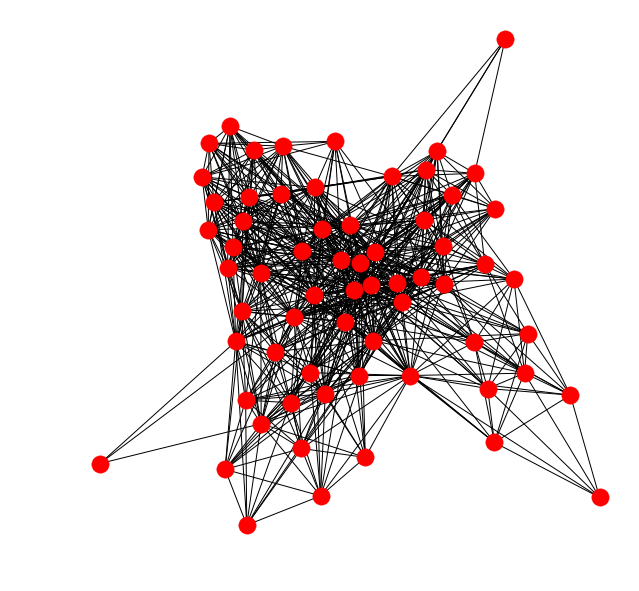

In [78]:
# This graph is unweighted, undirected(!)
graph = nx.read_edgelist(f'{os.getcwd()}/Data/bn/bn-cat-mixed-species_brain_1.edges')
fig, ax = plt.subplots(); nx.draw(graph, nx.spring_layout(graph))
print(f'Nodes = {graph.number_of_nodes()}\nEdges = {graph.number_of_edges()}')

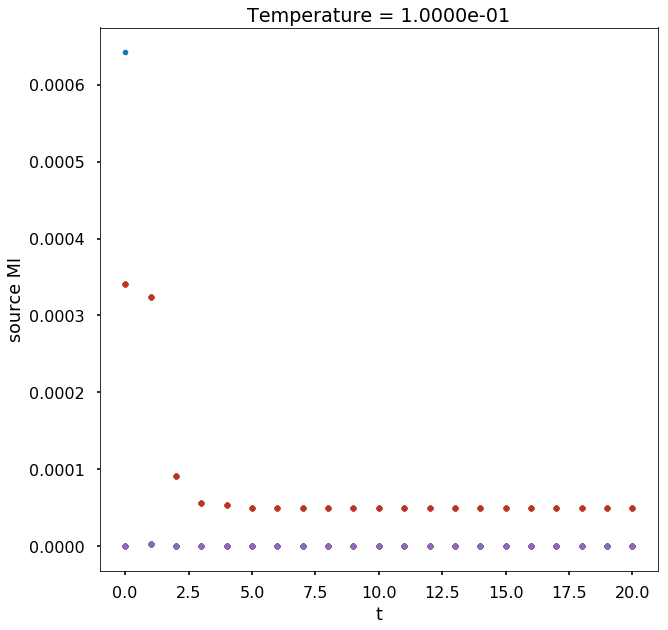

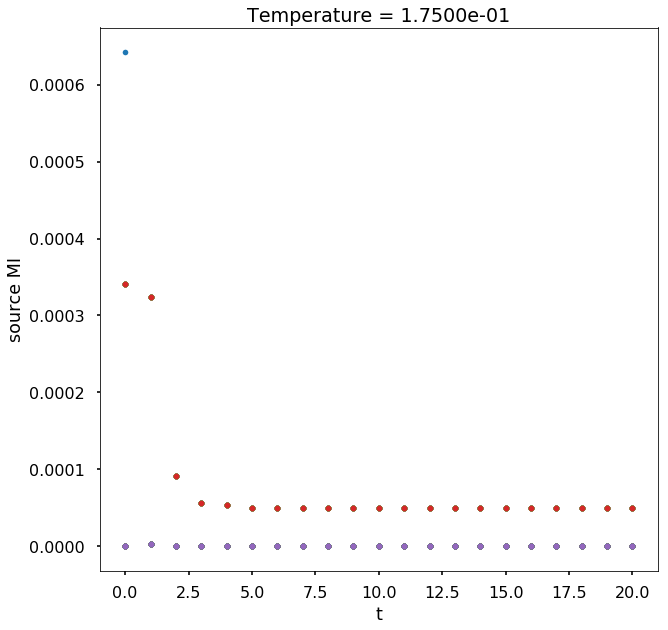

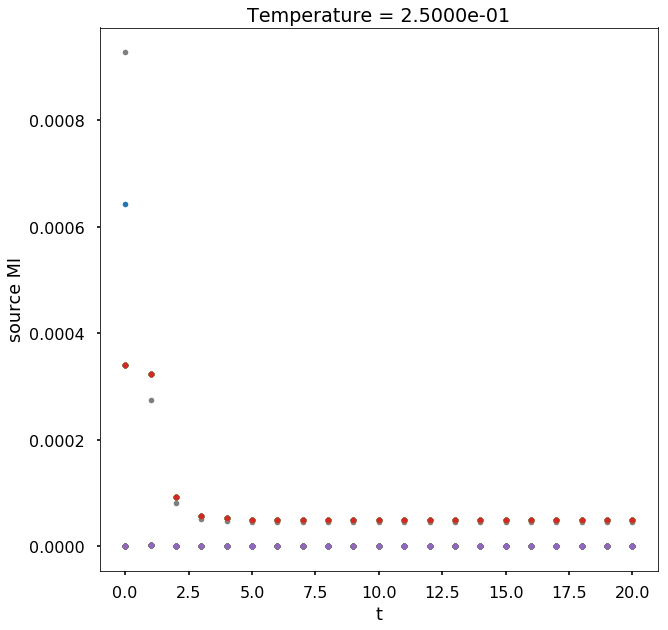

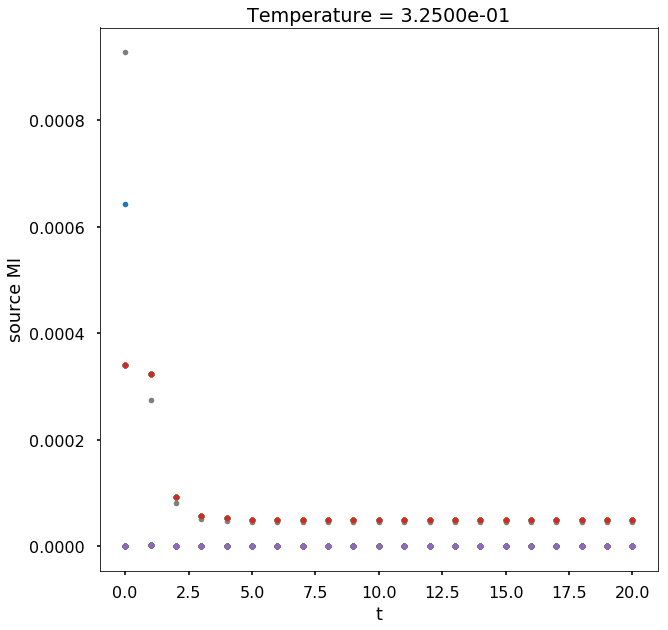

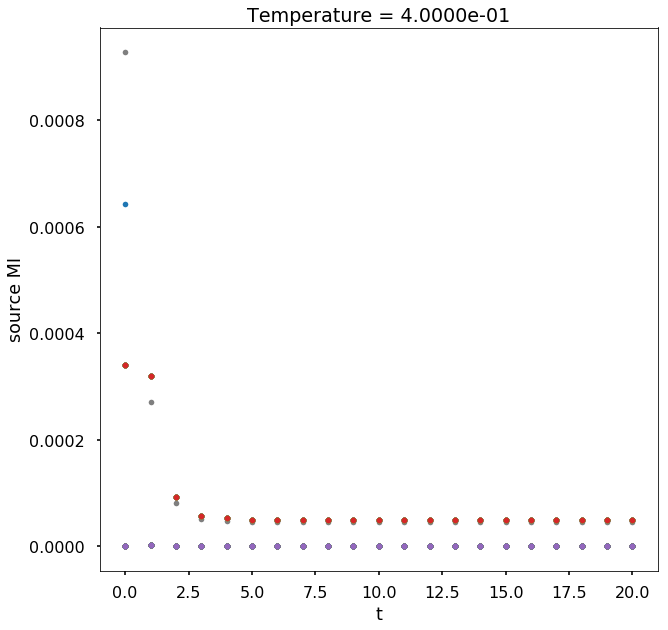

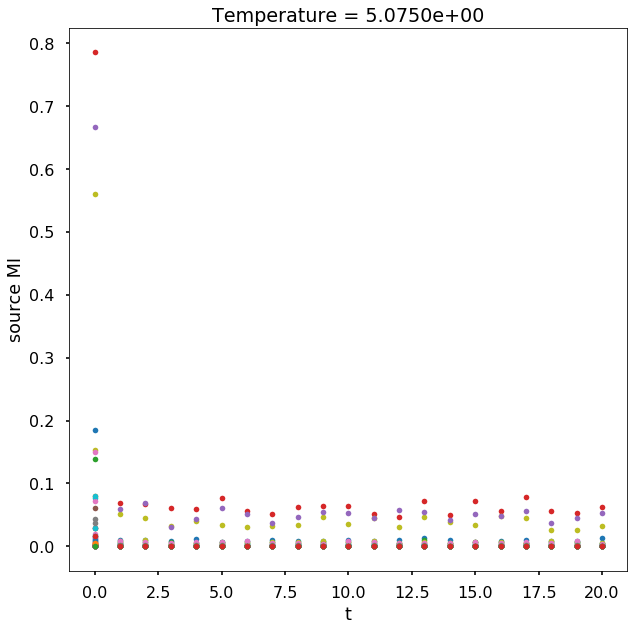

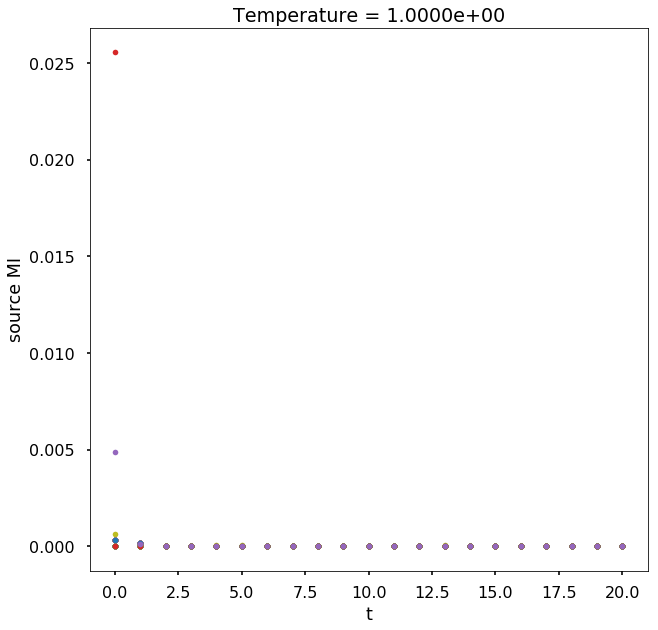

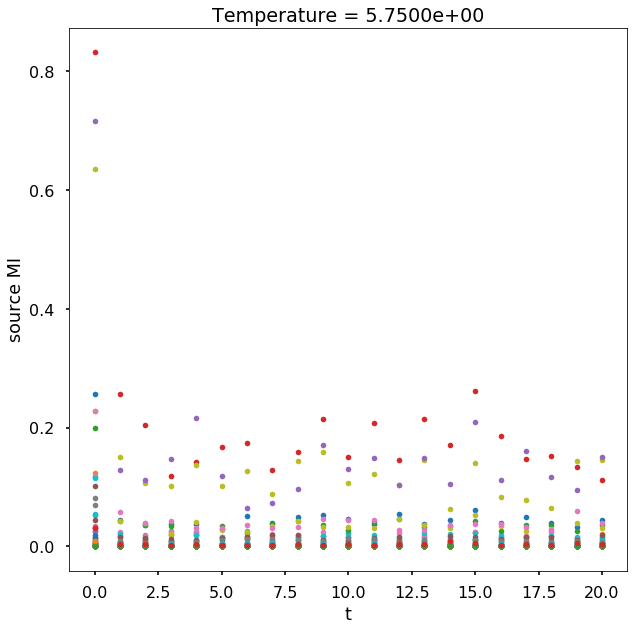

In [79]:
for file in os.listdir(data):
    if file.endswith('65.pickle'):
        I = IO.loadPickle(f'{data}{file}')['I']
        fig, ax = plt.subplots()
        ax.plot(I, '.')
        t = file.split('T=')[1].split('_')[0]
        plt.setp(ax, **dict(xlabel = 't', ylabel = 'source MI', title = f'Temperature = {t}'))
plt.rcParams['figure.figsize'] = (10,10)
sb.set_context('poster')

The graph above hasn't been fully analyzed. The idea was to to see whether we can observe different colors taking over as a functin of temperature. From T=5 there seems to be enough energy in the system for the MI curves to diverge. However, we run into problem O3; it will suddenlty find 10k + states which will generate issues. 

# O3
There are two major problems with the current implementation of the code:
1. The speed; it needs to be faster. Through a long debugging process I noticed that the code is not slow in directly sampling the states. The slowdown was mainly found in the Monte-carlo sampling. 
2. The memory usage. Again sampling of large systems (i.e. 200 x 200 = 40 000 nodes) is pretty fast, i.e. it can sample that size for 100_000 samples in about 2 minutes, but the Monte-Carlo samples is a very costly procedure; memory issues.

The speed can be tackled by converting the code to C using cython. The problem is that a full conversion will yield maximum speed, however certain things I used a very pythonic, so the gains here are not capped and can be improved. So far I started with statically typing the ising model such that the sampling of the system will be as fast as can be. Current speed up as circa **40-50** percent(!).

The memory is a different beast I need to tackle. As indicated above, the major problem is localized in the monte-carlo sampling. I currently work on a machine with 24 Gb of ram. The first thing I tried is to move from double precision floats to single precision, effectively halving the memory load by just this single step. This however, still yields issues. The issues are found in :
1. The multiprocess module of python cannot pipe very large files
2. If it returns a large file, swapping will cause a crash a lot of the time

I am not entirely sure why the large arrays from MC sampling don't fit in memory, as through back of the napkin calculations should allow me to use these sizes in my memory. This leads me to believe that there is some overhead either in the multiprocessing module, or some other parts of the code. The current hotfix I applied is to open a memmap; however the piping process of the multiprocess module is still there. Hence, either I need to use imap to return smaller parts of the array to reduce stress on the pipes or use single threads with a IO type interface. Both methods are not preferred as this requires me to rewrite lots of functions (diminshing returns). 